In [15]:
# A cyber disinformation detection briefing system
#System Architecture : Fetch -> Analyse -> Digest -> Translate -> Summarize
#Tech Stach :  Crawling -> SERPAPI
#              DB -> Postgres
#              Analysis -> gemini-2.5-flash
#              Translation -> gemini-2.5-flash
#              Briefing generation -> gemini-2.5-flash
#              Workflow Orchestration -> Langgraph

In [16]:
#-------------------------------------------------------------------------------
# 1. install and imports
#-------------------------------------------------------------------------------

!pip install -q langchain-community langgraph langchain-google-genai google-genai psycopg2-binary google-generativeai google-search-results



In [17]:
import os
import psycopg2
from google import genai
from google.genai import types
from serpapi import GoogleSearch
from langgraph.graph import START, StateGraph, END
from typing import TypedDict, List, Dict
from IPython.display import Markdown, Image

In [19]:
# Make sure to set your API keys in Colab:
# Set API Keys in the environment
from google.colab import userdata
import os

genai_api_key = userdata.get('GOOGLE_API_KEY')
os.environ['GOOGLE_API_KEY'] = genai_api_key

serper_api_key = userdata.get('SERPER_API')
os.environ['SERPER_API'] = serper_api_key

client = genai.Client()
default_model="gemini-2.5-flash"

In [20]:
# System message for Briefing Bot
system_message = """
You are an intelligence analyst specializing in DISINFORMATION DETECTION and cybersecurity RISK REPORTING.
Your task is to create OBJECTIVES, FACT-BASED, briefing reports fro news articles.

STRICT RULES:
1. DO NOT invent claims, actors or events.
2. ALWAYS attribute statements to their source(e.g.,"According to Xinhua...").
3. Clearly separate facts(what the outlet published) from analysis(disinformation framing, propaganda, sentiment).
4. Use neutral, professional language(no creative writing)
5. IF an article contains unverifiable claims, mark them explicitly as "claim by [outlet]" or "unverified".

Output Format:
1. Outlet and Source URL(Where information comes from).
2. Main Narritive/Cliams(quoted for paraphrased with attribution).
3. Analysis (possible propaganda/disinformation pattern, tone).
4. Credibility notes(confidence, any missing sources, cross-check needs)

The Goal is to generate a CREDIBLE analyst briefing that other professionals can rely on. DO NOT speculate. DO NOT embellish. Stick to cited sources.
"""


In [21]:
#Build a TypedDict Class to store state
from typing_extensions import TypedDict

class BriefingState(TypedDict):
  outlet: str
  url: str
  country: str
  translated_digest: str
  articles: List[Dict] # list of {title, link, snippet, text, meta}
  summaries: List[str] # list of generated summaries
  final_report: str

In [22]:
#Databse Utilities / Impl later on
def db_connect():
  return psycopg2.connect(
      dbname="knowledge",
      user="admin",
      password="admin",
      host="127.0.0.1",
      port="5432"
  )

  def save_article(outlet, url, title, text, lang="en"):
    conn = db_connect()
    cur = conn.cursor()
    cur.execute(
        "INSERT INTO articles (outlet_id, url, title, text, language) VALUES ((SELECT id FROM outlets WHERE name=%s), %s, %s, %s, %s) RETURNING id",
        (outlet, url, title, text, lang)
    )
    article_id = cur.fetchone()[0]
    conn.commit()
    cur.close()
    conn.close()
    return article_id

# Nodes

In [23]:
# 1. Fetch Node -> top n articles
def fetch_articles(state: BriefingState, top_n : int = 3): #top 3 for now
  """
  Use SerpAPI to fetch articles from the internet.
  """
  params = {
      "engine" : "google_news",
      "q" : f"site:{state['url']}",
      "hl" : "en",
      "gl" : "us",
      "api_key" : serper_api_key
  }
  search = GoogleSearch(params)
  results = search.get_dict()

  articles = []

  for news in results.get("news_results", [])[:top_n]:
    articles.append({
        "title": news.get("title", ""),
        "link": news.get("link", ""),
        "snippet": news.get("snippet", ""),
        "meta": news
    })

  state["articles"] = articles
  return state

In [24]:
# 2. Analyse Node ->
def analyse_articles(state: BriefingState):
  analysed = []

  for article in state["articles"]:
    prompt = f"""
    Analyse this news piece for disinformation patterns.
    Identify Narritve type, propaganda score (0-1), sentiment.

    Title: {article['title']}
    Snippet: {article['snippet']}
    """
    response = client.models.generate_content(
        model=default_model,
        config=types.GenerateContentConfig(
        system_instruction=system_message),
        contents= prompt)

    article['analysis'] = response.text
    analysed.append(article)

  state["articles"] = analysed
  return state

  state["articles"] = analysed
  return state

In [25]:
# 3. Digest Node
def digest_articles(state: BriefingState):
    for article in state["articles"]:
        prompt = f"""
        Extract key claims, actors, and arguments from this news:

        Title: {article['title']}
        Snippet: {article['snippet']}
        """
        response = client.models.generate_content(
            model=default_model,
            contents=prompt
        )
        article["digest"] = response.text
    return state

In [26]:
# 4. Translate Node
def translate_digest(state: BriefingState):
    for article in state["articles"]:
        prompt = f"""
        Translate the following digest into English, keep both original and translated:

        Digest: {article["digest"]}
        """
        response = client.models.generate_content(
            model=default_model,
            contents=prompt
        )
        article["translated_digest"] = response.text
    return state

In [27]:
# 5. Summarize Node
def summarize_articles(state: BriefingState):
    summaries = []
    for article in state["articles"]:
        prompt = f"""
        Write a briefing summary for cybersecurity analyst:
        Outlet: {state['outlet']} ({state['country']})
        Title: {article['title']}
        Analysis: {article['analysis']}
        Claims: {article['digest']}
        Translation: {article['translated_digest']}
        """
        response = client.models.generate_content(
        model=default_model,
        config=types.GenerateContentConfig(
        system_instruction=system_message),
        contents= prompt)

        summaries.append(response.text)
    state["summaries"] = summaries
    state['final_report'] = "\n\n---\n\n".join(summaries)
    return state
    return state


# Graph writing

In [28]:
graph = StateGraph(BriefingState)

graph.add_node("fetch", fetch_articles)
graph.add_node("analyse", analyse_articles)
graph.add_node("digest", digest_articles)
graph.add_node("translate", translate_digest)
graph.add_node("summarize", summarize_articles)

graph.set_entry_point("fetch")
graph.add_edge("fetch", "analyse")
graph.add_edge("analyse", "digest")
graph.add_edge("digest", "translate")
graph.add_edge("translate", "summarize")
graph.add_edge("summarize", END)

briefing_bot = graph.compile()

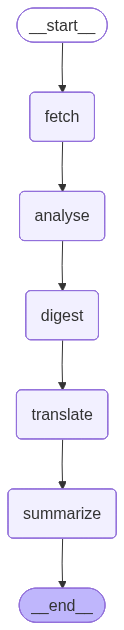

In [29]:
#display the flow
display(Image(briefing_bot.get_graph().draw_mermaid_png()))

In [30]:
# Test run
state = {
    "outlet" : "Xinhua News Agency",
    "url" : "english.news.cn",
    "country" : "Multiple",
    "articles" : [],
    "summaries" : [],
    "final_report" : ""
}

result = briefing_bot.invoke(state)
print(result["final_report"])

**Analyst Briefing Summary**

---

1.  **Outlet and Source URL:**
    *   **Outlet:** Xinhua News Agency
    *   **Source URL:** Not provided in the input.

2.  **Main Narrative/Claims:**
    *   **According to the title "Ugandan official confirms UAE's new visa restrictions," the following claims are presented:**
        *   The United Arab Emirates (UAE) has implemented new visa restrictions.
        *   A Ugandan official has confirmed these new visa restrictions.
    *   **Actors mentioned:** A Ugandan official, the United Arab Emirates (UAE).

3.  **Analysis:**
    *   **Disinformation/Propaganda Patterns:** No analysis of disinformation or propaganda patterns can be conducted as the full article content is not available. The provided information is limited to a headline.
    *   **Tone:** The headline itself is factual and neutral in tone, reporting an official confirmation of an event. Without the article, further tone assessment is not possible.

4.  **Credibility Notes:**
    